In [1]:
# Set parent path for imports.

import os
import sys

# Get desired path:
path = os.path.dirname(os.path.dirname(os.getcwd()))

# Add the parent directory to sys.path
sys.path.append(path)

In [2]:
import numpy as np

from statespace.models import BrownianLangevinModel
from statespace.methods import KalmanFilter

import pandas as pd
import matplotlib.pyplot as plt

# Generate data:

In [16]:
T = np.linspace(0, 100, num=1000).reshape(-1, 1)

generative_state_shape = (2,1)
generative_theta = -0.2
generative_sigma = 1.
generative_sigma_eps = 0.1

generative_model = BrownianLangevinModel(theta=generative_theta, sigma=generative_sigma, sigma_eps=generative_sigma_eps, shape=generative_state_shape)

In [17]:
# Print parameter values:
generative_model.get_parameter_values()

{'theta': -0.2, 'sigma': 1.0, 'sigma_eps': 0.1}

In [18]:
x, y = generative_model.sample(times=T)

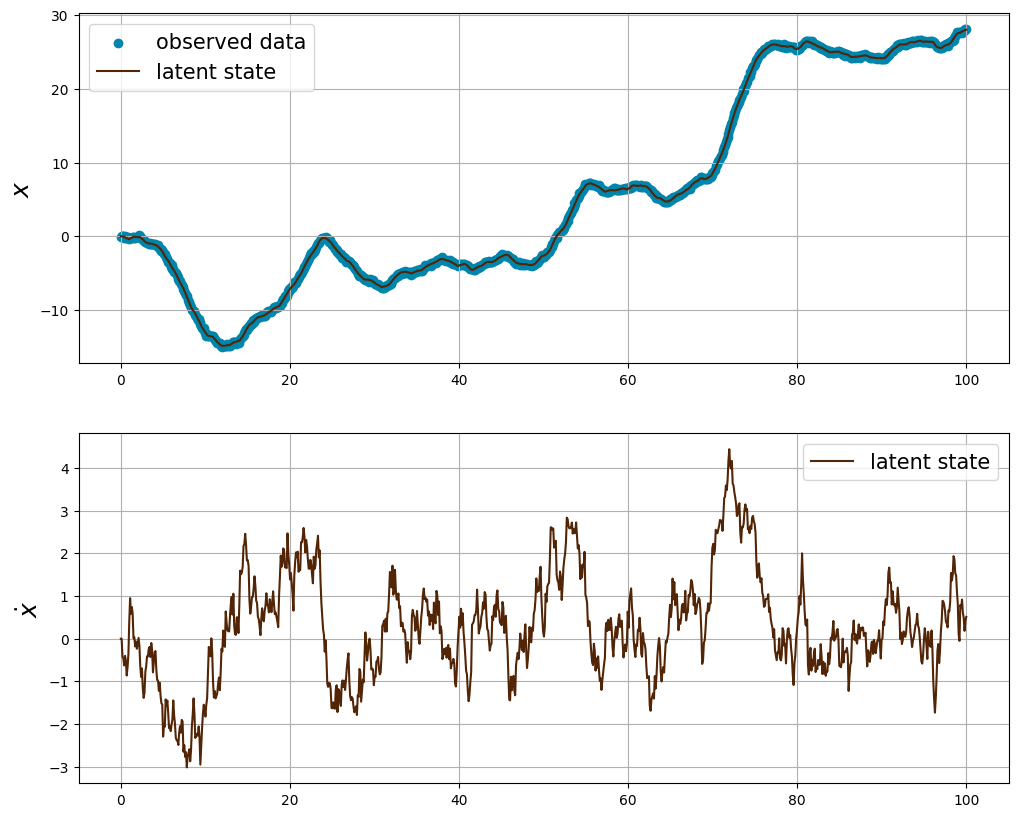

In [19]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

# Inference

Given an array of time points T, and observations y, estimate the states (and parameters).

## Kalman filtering:

In [25]:
state_shape = (2,1)
theta = -0.2
sigma = 1.
sigma_eps = 0.1

model = BrownianLangevinModel(theta=theta, sigma=sigma, sigma_eps=sigma_eps, shape=state_shape)
model.get_parameter_values()

{'theta': -0.2, 'sigma': 1.0, 'sigma_eps': 0.1}

In [26]:
# Initialise arrays
x_init = np.random.normal(loc=0., scale=0.1, size=state_shape)

P_init = np.random.normal(loc=0., scale=1., size=(state_shape[0], state_shape[0]))
P_init = np.matmul(P_init.T, P_init)

In [27]:
inference_method = KalmanFilter(model=model, prior=None, proposal=None)
history = inference_method.filter(times=T, y=y, x_init=x_init, P_init=P_init)

The prior configuration is not valid.


In [28]:
x_est = inference_method.x_est
P_est = inference_method.P_est

post_vars = np.array([np.diag(COV) for COV in P_est[1:,:,:]])
predictive_vars = post_vars + inference_method.model.eps.covariance()

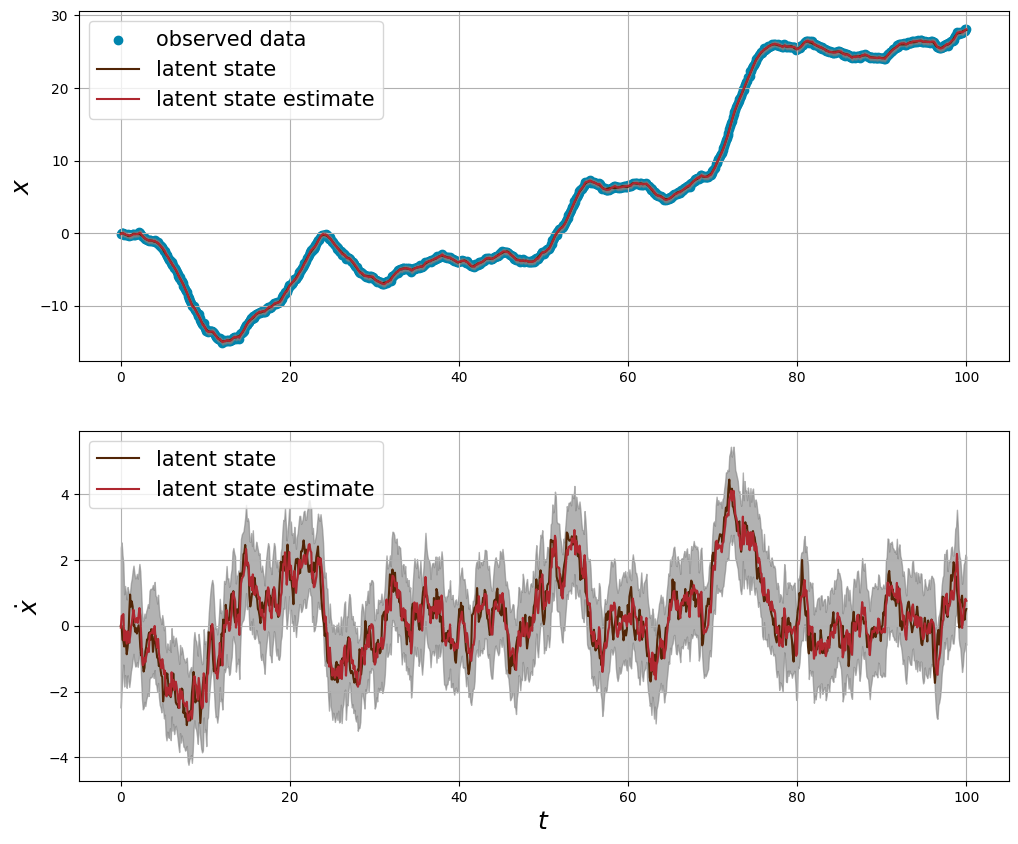

In [29]:
fig, ax = plt.subplots(nrows=2, figsize=(12,10))

# Plot observations:
ax[0].scatter(T, y[:,0,:], color="#0085ad", label="observed data")
ax[0].plot(T, y[:,0,:], color="#0085ad", lw=0.8)

# Plot state:
ax[0].plot(T, x[:,0,:], color="#522506", label="latent state")

# Plot state estimate:
ax[0].plot(T, x_est[1:,0,:], color="#AF272F", label="latent state estimate")
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.7)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(post_vars[:, 0]), color='grey', alpha=0.7)

# Plot predictive uncertainty:
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() + 3 * np.sqrt(predictive_vars[:, 0]), color='grey', alpha=0.4)
ax[0].fill_between(T.flatten(), x_est[1:,0,:].flatten(), x_est[1:,0,:].flatten() - 3 * np.sqrt(predictive_vars[:, 0]), color='grey', alpha=0.4)

# Settings:
ax[0].legend(fontsize=15)
ax[0].set_ylabel(r"$x$", fontsize=18)
ax[0].grid(True)

# Plot velocity state:
ax[1].plot(T, x[:,1,:], color="#522506", label="latent state")

# Plot velocity state estimate:
ax[1].plot(T, x_est[1:,1,:], color="#AF272F", label="latent state estimate")
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() + 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)
ax[1].fill_between(T.flatten(), x_est[1:,1,:].flatten(), x_est[1:,1,:].flatten() - 3 * np.sqrt(post_vars[:, 1]), color='grey', alpha=0.6)

# Settings:
ax[1].set_xlabel(r"$t$", fontsize=18)
ax[1].legend(fontsize=15)
ax[1].set_ylabel(r"$\dot{x}$", fontsize=18)
ax[1].grid(True)

plt.show()

In [30]:
# Compute basic results:

observation_space_latent_error = x_est[1:,0,:] - x[:,0]
latent_space_error = x_est[1:,1,:] - x[:,1]

# Compute MAPE:

observation_space_percentage_error = (observation_space_latent_error/x[:,0])
observation_space_percentage_error = observation_space_percentage_error[np.isfinite(observation_space_percentage_error)]

observation_space_mape = np.abs(observation_space_percentage_error).sum() / observation_space_percentage_error.size
print(f"Observation space MAPE of state: {observation_space_mape}")

latent_space_percentage_error = (latent_space_error/x[:,1])
latent_space_percentage_error = latent_space_percentage_error[np.isfinite(latent_space_percentage_error)]

latent_space_mape = np.abs(latent_space_percentage_error).sum() / latent_space_percentage_error.size
print(f"Latent space MAPE of state: {latent_space_mape}")

# Compute MSE:

observation_space_mse = (observation_space_latent_error**2).sum() / observation_space_latent_error.size
print(f"Observation space MSE of state: {observation_space_mse}")

latent_space_mse = (latent_space_error**2).sum() / latent_space_error.size
print(f"Latent space MSE of state: {latent_space_mse}")

Observation space MAPE of state: 0.04372281093412741
Latent space MAPE of state: 7.408596018947286
Observation space MSE of state: 0.0057006800228287646
Latent space MSE of state: 0.20169914338505532


/var/folders/kz/7d9nbyzs2hs58pn0w3f1v5880000gn/T/ipykernel_12803/216733359.py:8: RuntimeWarning: divide by zero encountered in divide
  observation_space_percentage_error = (observation_space_latent_error/x[:,0])
/var/folders/kz/7d9nbyzs2hs58pn0w3f1v5880000gn/T/ipykernel_12803/216733359.py:14: RuntimeWarning: divide by zero encountered in divide
  latent_space_percentage_error = (latent_space_error/x[:,1])
